## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  my goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


Analysis was conducted using 3 approaches - probabilistic reasoning, hypothesis testing and logistic regression to cross examine the results produced and draw conclusions.

Tool: Jupter Notebook (Python)

Programming library: panda, numpy, matplotlib, statsmodels



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [21]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [22]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [23]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [24]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [25]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [26]:
mismatch = df[((df.group == 'treatment') & (df.landing_page!='new_page')) | ((df.group == 'control') & (df.landing_page != 'old_page'))]
mismatch.count()[0]


3893

f. Do any of the rows have missing values?

In [27]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  



In [28]:
df2 = df.drop(mismatch.index)

In [29]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [30]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [31]:
duplicated_user=df2[df2.user_id.duplicated()]
duplicated_user

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [32]:
duplicated_user

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**

In [33]:
df2.drop_duplicates('user_id',inplace = True)



 What is the probability of an individual converting regardless of the page they receive?

In [34]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [35]:
obs_p_old=df2[df2['group']=='control'].converted.mean()

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [36]:
obs_p_new= df2[df2['group']=='treatment'].converted.mean()

In [37]:
obs_diffs=obs_p_new-obs_p_old

d. What is the probability that an individual received the new page?

In [38]:
df2[df2['landing_page']=='new_page'].count()[0]/df2.count()[0]


0.50006194422266881

 Is there a sufficient evidence to conclude that the new treatment page leads to more conversions?

**There is no sufficient evidence as the mean of conversion regardless of groups is the same of the mean in treatment group who recieved the new page
furthermore the mean in control group is more than the mean in treatment**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider I need to make the decision just based on all the data provided.  If I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should null and alternative hypotheses be?  

**null hypothesis is
$p_{new}$** - **$p_{old}$** < 0 <br> <br><br>
**alternative hypothesis is
$p_{new}$** - **$p_{old}$** > 0 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>



a. What is the **conversion rate** for $p_{new}$ under the null? 

In [39]:
p_new= df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [40]:
p_old= df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [41]:
n_new= df2.query('group== "treatment" ').count()[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [42]:
n_old= df2.query('group== "control"').count()[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [43]:
new_page_converted= np.random.binomial(n_new, p_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [44]:
old_page_converted = np.random.binomial(n_old, p_old)

g. Find $p_{new}$ - $p_{old}$ for simulated values from part (e) and (f).

In [45]:
new_page_converted/n_new - old_page_converted/n_old


0.0015672490951005313

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process  used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [46]:
p_diffs = []
for _ in range(10000):
    new_page_converted= np.random.binomial(n_new, p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    p_diffs.append(new_page_converted/n_new - old_page_converted/n_old)
p_diffs = np.array(p_diffs)    

i. Plot a histogram of the **p_diffs**. 

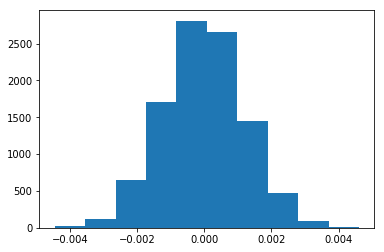

In [47]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [48]:
(p_diffs>obs_diffs).mean()

0.90149999999999997

**This value called p value, it means that under null hypothesis there is 10% chance for difference of mean  to be as we observed ,and that mean there is no evidence to reject null hypothesis**

calculate the number of conversions for each page, as well as the number of individuals who received each page.  `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [50]:
import statsmodels.api as sm

convert_old = df2.query('group== "treatment"').converted.sum()
convert_new = df2.query('group== "control"').converted.sum()
n_old = df2.query('group== "control"').count()[0]
n_new = df2.query('group== "treatment" ').count()[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


 Now use `stats.proportions_ztest` to compute your test statistic and p-value. 

In [52]:
 sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='smaller')

(1.2616957421858055, 0.89647085519672265)

**z score mean that observed conversion rate is 1 standard deviation apart from the mean**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion,we will perform **logistic regression** 

b. The goal is to use **statsmodels** to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives. However, we first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [48]:
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2['intercept'] = 1


c. Use **statsmodels** to instantiate our regression model on the two columns we created in part b., then fit the model using the two columns we created in part **b.** to predict whether or not an individual converts. 

In [49]:
log_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page' ]])
results = log_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. The summary of the model 

In [50]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 29 Oct 2019   Pseudo R-squ.:               8.077e-06
Time:                        16:09:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? 

**p value= .190 ,it differ from the value  found in Part II because this is 2 tailed test but in part 2 is is one tailed**

**we will add other variables to try to explain as much variation in convert as possible, potential problems are Non-linearity of the response-predictor relationships<br>
Correlation of error terms<br>
Non-constant Variance and Normally Distributed Errors<br>
Outliers/ High leverage points<br>
Multicollinearity**



Does it appear that country had an impact on conversion? 

In [53]:
countries=pd.read_csv('countries.csv')
df3=df2.set_index('user_id').join(countries.set_index('user_id'))

In [61]:
df3['CA'] = pd.get_dummies(df3['country'])['CA']
df3['UK']= pd.get_dummies(df3['country'])['UK']
log_mod = sm.Logit(df3['converted'], df3[['intercept','CA','UK','ab_page' ]])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 29 Oct 2019   Pseudo R-squ.:               2.323e-05
Time:                        16:16:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

from p value it's appear that country has no impact on conversion

 we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  



In [64]:
df3["CA_page"] = df3["ab_page"]*df3["CA"]

df3["UK_page"] = df3["ab_page"]*df3["UK"]

log_mod = sm.Logit(df3['converted'], df3[['intercept','CA_page','UK_page' ]])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 29 Oct 2019   Pseudo R-squ.:               2.364e-05
Time:                        16:23:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                   0.08085
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9963      0.006   -322.049      0.000      -2.008      -1.984
CA_page       -0.0752      0.038     -1.997      0.046      -0.149      -0.001
UK_page        0.0149      0.017      0.862      0.389      -0.019       0.049
==============================================================================
"""

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])